# Importing GDS files

In Tidy3D, complex structures can be defined or imported from GDSII files via the third-party [gdstk](https://heitzmann.github.io/gdstk/) package. In this tutorial, we will first illustrate how to use the package to define a structure, then we will save this to file, and then we will read that file and import the structures in a simulation.

<img src="img/splitter.png" alt="Schematic of the directional coupler" width="400"/>

Note that this tutorial requires gdstk, so grab it with `pip install gdstk` before running the tutorial or uncomment the cell line below.

We also provide a conprehensive list of other tutorials such as [how to define boundary conditions](https://www.flexcompute.com/tidy3d/examples/notebooks/BoundaryConditions/), [how to compute the S-matrix of a device](https://www.flexcompute.com/tidy3d/examples/notebooks/SMatrix/), [how to interact with tidy3d's web API](https://www.flexcompute.com/tidy3d/examples/notebooks/WebAPI/), and [how to define self-intersecting polygons](https://www.flexcompute.com/tidy3d/examples/notebooks/SelfIntersectingPolyslab/).

If you are new to the finite-difference time-domain (FDTD) method, we highly recommend going through our [FDTD101](https://www.flexcompute.com/fdtd101/) tutorials. 

In [1]:
# standard python imports
import numpy as np
import matplotlib.pyplot as plt
import gdstk
import os

# tidy3d import
import tidy3d as td
from tidy3d import web

## Creating the geometry with gdstk

In this section, we will construct an integrated adiabatic coupler as in the title image in this notebook using `gdstk`. If you are only interested in importing an already existing GDSII file, just jump ahead to the next section.

We create a function that generates the coupler and returns the correcponding cell. The geometry is built by defining the cross-section of the device in the x-y plane. The cross section can be supplied at the `top`, `bottom`, or the `middle` of the device, specified by the parameter `reference_plane`. Here we choose to define the cross section on the base. There, the two arms of the device start at a distance `wg_spacing_in` apart, then come together at a coupling distance `wg_spacing_coup` for a certain length `coup_length`, and then split again into separate ports. In the coupling region, the field overlap results in energy exchange between the two waveguides. The cell also includes a rectangle around the whole device, which we will use as substrate later. The waveguides use GDS layer 1 and the rectangle layer 0.

Here, we will only see how to define, export, and import such a device using `gdstk`. When importing the device, we can optionally dilate or erode its cross section via `dilation`. In a later example we will simulate the device and study the frequency dependence of the transmission into each of the ports.

In [2]:
def make_coupler(
    length: float,
    wg_spacing_in: float,
    wg_width: float,
    wg_spacing_coup: float,
    wg_spacing_side: float,
    coup_length: float,
    bend_length: float,
) -> gdstk.Cell:
    """Make an integrated coupler using the gdstk RobustPath object."""
    input_length = length / 2 - coup_length / 2 - bend_length
    if input_length <= 0:
        raise ValueError(
            "Device length must be larger than coupling length plus bending regions."
        )

    delta = (wg_spacing_in - (wg_spacing_coup + wg_width)) / 2
    turn_angle = 2 * np.arctan(delta / bend_length)
    bend_radius = bend_length / 2 / np.sin(turn_angle)
        
    coup = gdstk.RobustPath(
        (-0.5 * length, wg_spacing_in / 2), wg_width, simple_path=True, layer=1,
    )
    coup.segment((input_length, 0), relative=True)
    coup.turn(bend_radius, -turn_angle)
    coup.turn(bend_radius, turn_angle)
    coup.segment((coup_length, 0), relative=True)
    coup.turn(bend_radius, turn_angle)
    coup.turn(bend_radius, -turn_angle)
    coup.segment((0.5 * length, wg_spacing_in / 2))

    arm_cell = gdstk.Cell("COUPLER_ARM")
    arm_cell.add(coup)

    cell = gdstk.Cell("COUPLER")
    cell.add(gdstk.Reference(arm_cell))
    cell.add(gdstk.Reference(arm_cell, x_reflection=True))

    substrate = gdstk.rectangle(
        (-device_length / 2, -(wg_spacing_in + wg_width) / 2 - wg_spacing_side),
        (device_length / 2, (wg_spacing_in + wg_width) / 2 + wg_spacing_side),
        layer=0,
    )
    cell.add(substrate)
    return cell


We define some structural parameters. We consider the sidewall of the device to be slanted, deviating from the vertical sidewall by `sidewall_angle`. `sidewall_angle > 0` corresponds to a typical fabrication scenario where the base of the device is larger than the top.

In [3]:
### Lengths in micrometers

# Waveguide width
wg_width = 0.45

# Waveguide separation in the beginning/end
wg_spacing_in = 4

# Length of the coupling region
coup_length = 4

# Angle of the sidewall deviating from the vertical ones, positive values for the base larger than the top
sidewall_angle = np.pi / 6

# Reference plane where the cross section of the device is defined
reference_plane = "bottom"

# Length of the bend region
bend_length = 6

# Waveguide separation in the coupling region
wg_spacing_coup = 0.10

# Waveguide separation in the coupling region
wg_spacing_side = 4.0

# Total device length along propagation direction
device_length = 25


### Saving the geometry to a GDS file

Next, we construct the coupler and add the cell (including its dependencies) to a GDS library. The library is saved to a file, so that we can demosntrate how to load the geometry straight from a gds file. Alternatively, we could use the created cell directly.

In [4]:
# Create a gds cell to add our structures to
coup_cell = make_coupler(
    device_length, wg_spacing_in, wg_width, wg_spacing_coup, wg_spacing_side, coup_length, bend_length
)

# Create a library for the cell and save it, just so that we can demosntrate loading
# geometry from a gds file
gds_path = "misc/coupler.gds"

if os.path.exists(gds_path):
    os.remove(gds_path)

lib = gdstk.Library()
lib.add(coup_cell, *coup_cell.dependencies(True))
lib.write_gds(gds_path)


## Loading a GDS file into Tidy3D

To load the geometry from a GDSII file, we use gdstk to load the library and select the cell with the geometry we want.
It is usualy esier to create a dictionary of all the cells in the library to verify that we can find the correct one by name:

In [5]:
# Load a GDSII library from the file we just created
lib_loaded = gdstk.read_gds(gds_path)

# Create a cell dictionary with all the cells in the file
all_cells = {c.name: c for c in lib_loaded.cells}

print("Cell names: " + ", ".join(all_cells.keys()))


Cell names: COUPLER, COUPLER_ARM


In this case, we only have the single cell that we created previously, called “COUPLER”, but usually GDSII files hold tens to hundreds of cells, so it is important to find them by name. Getting to the cell we're interested in now is as simple as:

In [6]:
coup_cell_loaded = all_cells["COUPLER"]

print(coup_cell_loaded)


Cell 'COUPLER' with 1 polygons, 0 flexpaths, 0 robustpaths, 2 references, and 0 labels


### Set up Geometries

Then we can construct tidy3d geometries from the GDS cell we just loaded, along with other information such as the axis, sidewall angle, and bounds of the "slab". When loading GDS cell as the cross section of the device, we can tune ``reference_plane`` to set the cross section to lie at ``bottom``, ``middle``, or ``top`` of the generated [Polyslab](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.PolySlab.html) with respect to the axis. E.g. if ``axis=1``, ``bottom`` refers to the negative side of the y-axis, and ``top`` refers to the positive side of the y-axis. Additionally, we can optionally dilate or erode the cross section by setting `dilation`. A negative `dilation` corresponds to erosion.

Note, we have to keep track of the `gds_layer` and `gds_dtype` used to defined the GDS cell earlier, so we can load the right components.

In [7]:
# Define waveguide height
wg_height = 0.22
dilation = 0.02

substrate_geo = td.Geometry.from_gds(
    coup_cell_loaded,
    gds_layer=0,
    gds_dtype=0,
    axis=2,
    slab_bounds=(-4, 0),
    reference_plane=reference_plane,
)

arms_geo = td.Geometry.from_gds(
    coup_cell_loaded,
    gds_layer=1,
    gds_dtype=0,
    axis=2,
    slab_bounds=(0, wg_height),
    sidewall_angle=sidewall_angle,
    dilation=dilation,
    reference_plane=reference_plane,
)


Let's plot the base and the top of the coupler waveguide arms to make sure it looks ok. The base of the device should be larger than the top due to a positive `sidewall_angle`.

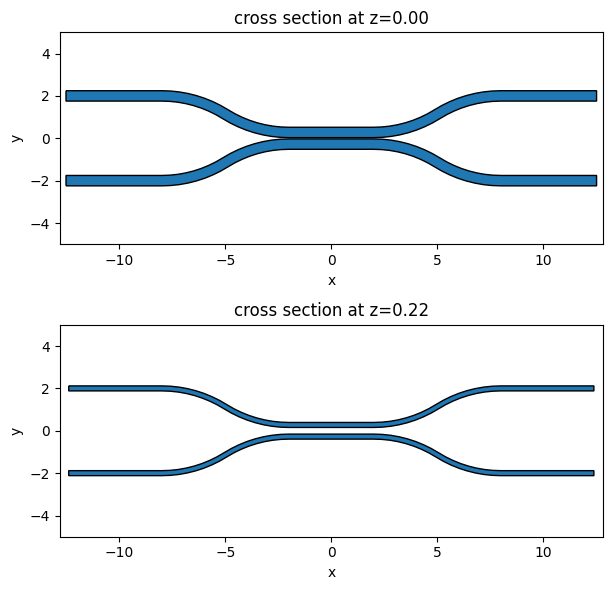

In [8]:
f, ax = plt.subplots(2, 1, figsize=(15, 6), tight_layout=True)
arms_geo.plot(z=0.0, ax=ax[0])
arms_geo.plot(z=wg_height, ax=ax[1])

ax[0].set_ylim(-5, 5)
_ = ax[1].set_ylim(-5, 5)

### Set up Structures

To make use of these new geometries, we need to load them into a tidy3d.Simulation as td.Structures with material properties.

We'll define the substrate and waveguide mediums and then link them up with the Polyslabs.

In [9]:
# Permittivity of waveguide and substrate
wg_n = 3.48
sub_n = 1.45
medium_wg = td.Medium(permittivity=wg_n**2)
medium_sub = td.Medium(permittivity=sub_n**2)

# Substrate
substrate = td.Structure(geometry=substrate_geo, medium=medium_sub)

# Waveguides
arms = td.Structure(geometry=arms_geo, medium=medium_wg)

structures = [substrate, arms]


### Set up Simulation

Now let's set up the rest of the Simulation.

In [10]:
# Spacing between waveguides and PML
pml_spacing = 1.0

# Simulation size
sim_size = list(arms_geo.bounding_box.size)
sim_size[0] -= 4 * pml_spacing
sim_size[1] += 2 * pml_spacing
sim_size[2] = wg_height + 2 * pml_spacing

sim_center = list(arms_geo.bounding_box.center)
sim_center[2] = 0

# grid size in each direction
dl = 0.020

### Initialize and visualize simulation ###
sim = td.Simulation(
    size=sim_size,
    center=sim_center,
    grid_spec=td.GridSpec.uniform(dl=dl),
    structures=structures,
    run_time=2e-12,
    boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),
)


Note: `Tidy3D` is warning us that our Simulation does not contain sources. In this case, since we are using the simulation as a demonstration and are not running any simulations, we may safely ignore this warning throughout this notebook.

### Plot Simulation Geometry

Let's take a look at the simulation all together with the PolySlabs added. Here the angle of the sidewall deviating from the vertical direction is 30 degree.

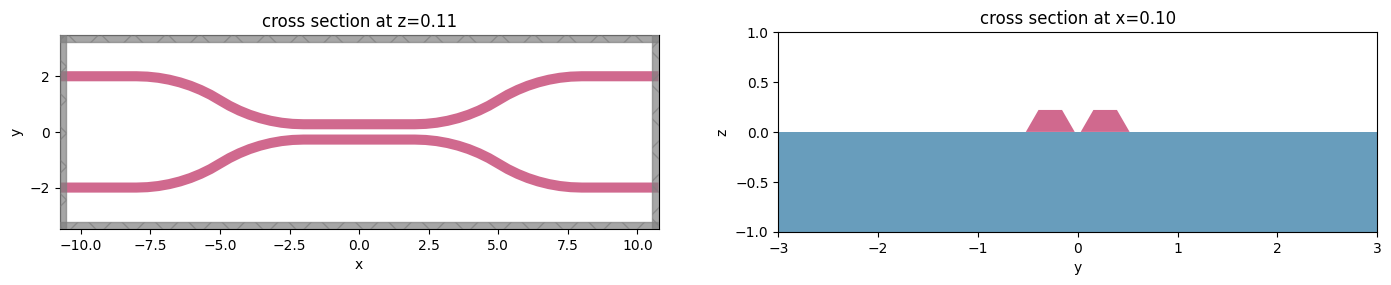

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 5))

sim.plot(z=wg_height / 2, lw=1, edgecolor="k", ax=ax1)
sim.plot(x=0.1, lw=1, edgecolor="k", ax=ax2)

ax2.set_xlim([-3, 3])
_ = ax2.set_ylim([-1, 1])
